In [1]:
import os
os.chdir('../../')
os.getcwd()

'/Users/henriquecosta/workspace/studies/modern-ml'

In [2]:
import catboost as cb
from sklearn.metrics import log_loss, average_precision_score
from sklearn.model_selection import train_test_split
import mlflow 
from matplotlib import pyplot as plt
import pandas as pd
import arfs.feature_selection.allrelevant as arfsgroot

/Users/henriquecosta/workspace/studies/modern-ml/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mlflow.set_experiment('feature_selection')

2025/02/02 16:21:38 INFO mlflow.tracking.fluent: Experiment with name 'feature_selection' does not exist. Creating a new experiment.


'file:///Users/henriquecosta/workspace/studies/modern-ml/mlruns/688941890086194690/34a2014b77a34b44b278b721d6f47e9a/artifacts'

In [4]:
df_train = pd.read_parquet('./case/data/processed/lending_club_case_train_dataset_v1.parquet')
df_test = pd.read_parquet('./case/data/processed/lending_club_case_test_dataset_v1.parquet')

<Axes: title={'center': 'Default rate over time'}, xlabel='issue_d'>

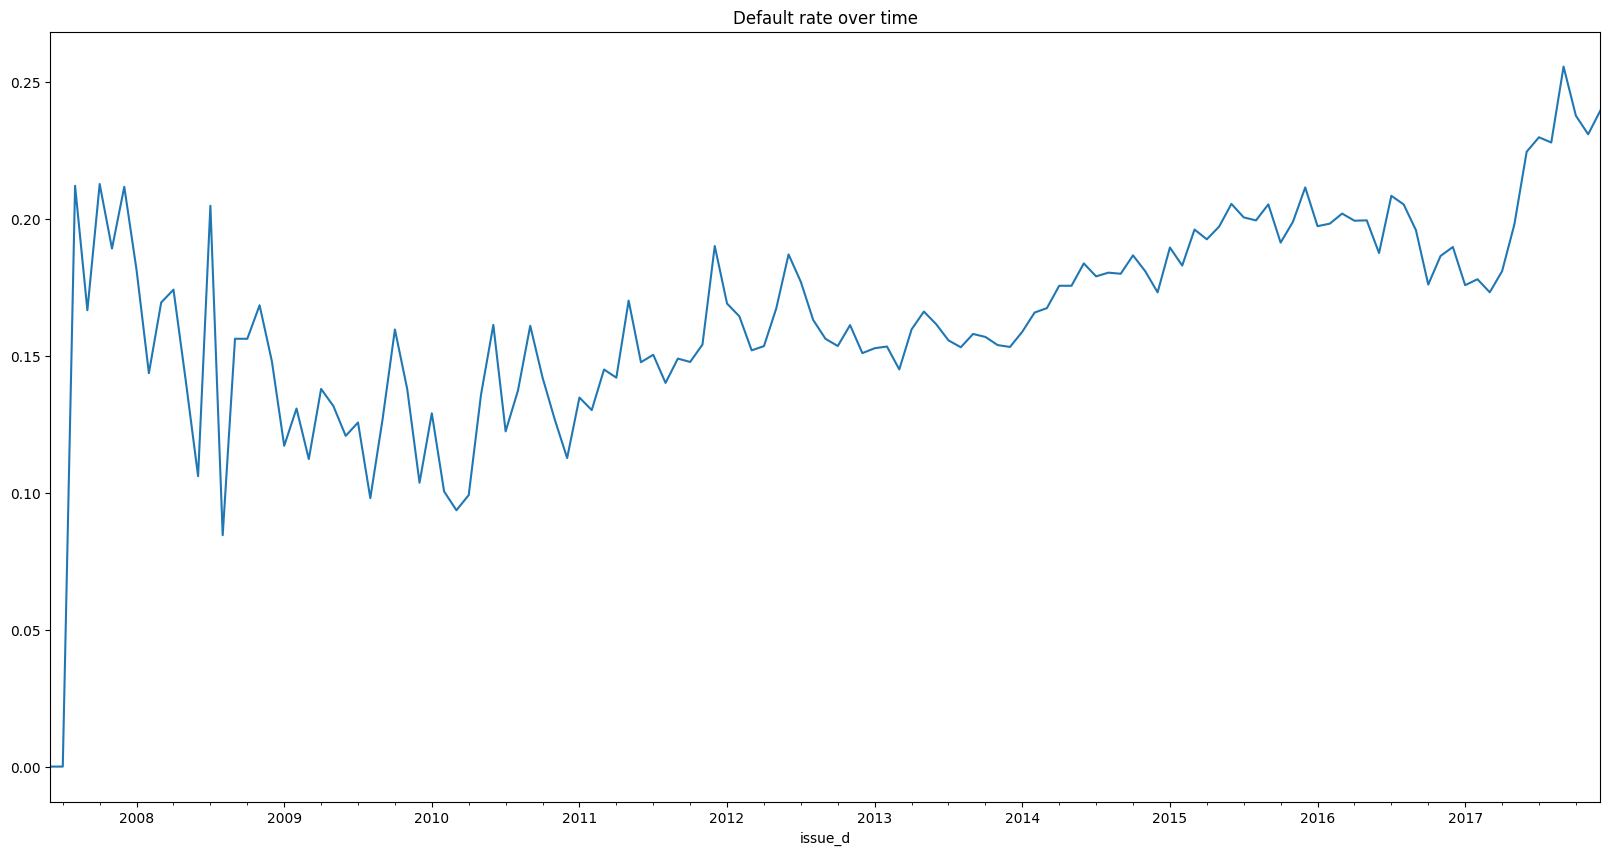

In [5]:
(
    df_train
    .groupby('issue_d')
    ['default']
    .mean()
    .plot(figsize=(20, 10), title='Default rate over time')
)

In [6]:
cut_off_date = '2017-06-01'

df_valid = df_train.loc[df_train['issue_d'] >= cut_off_date]
df_train = df_train.loc[df_train['issue_d'] < cut_off_date]

<Axes: title={'center': 'Default rate over time'}, xlabel='issue_d'>

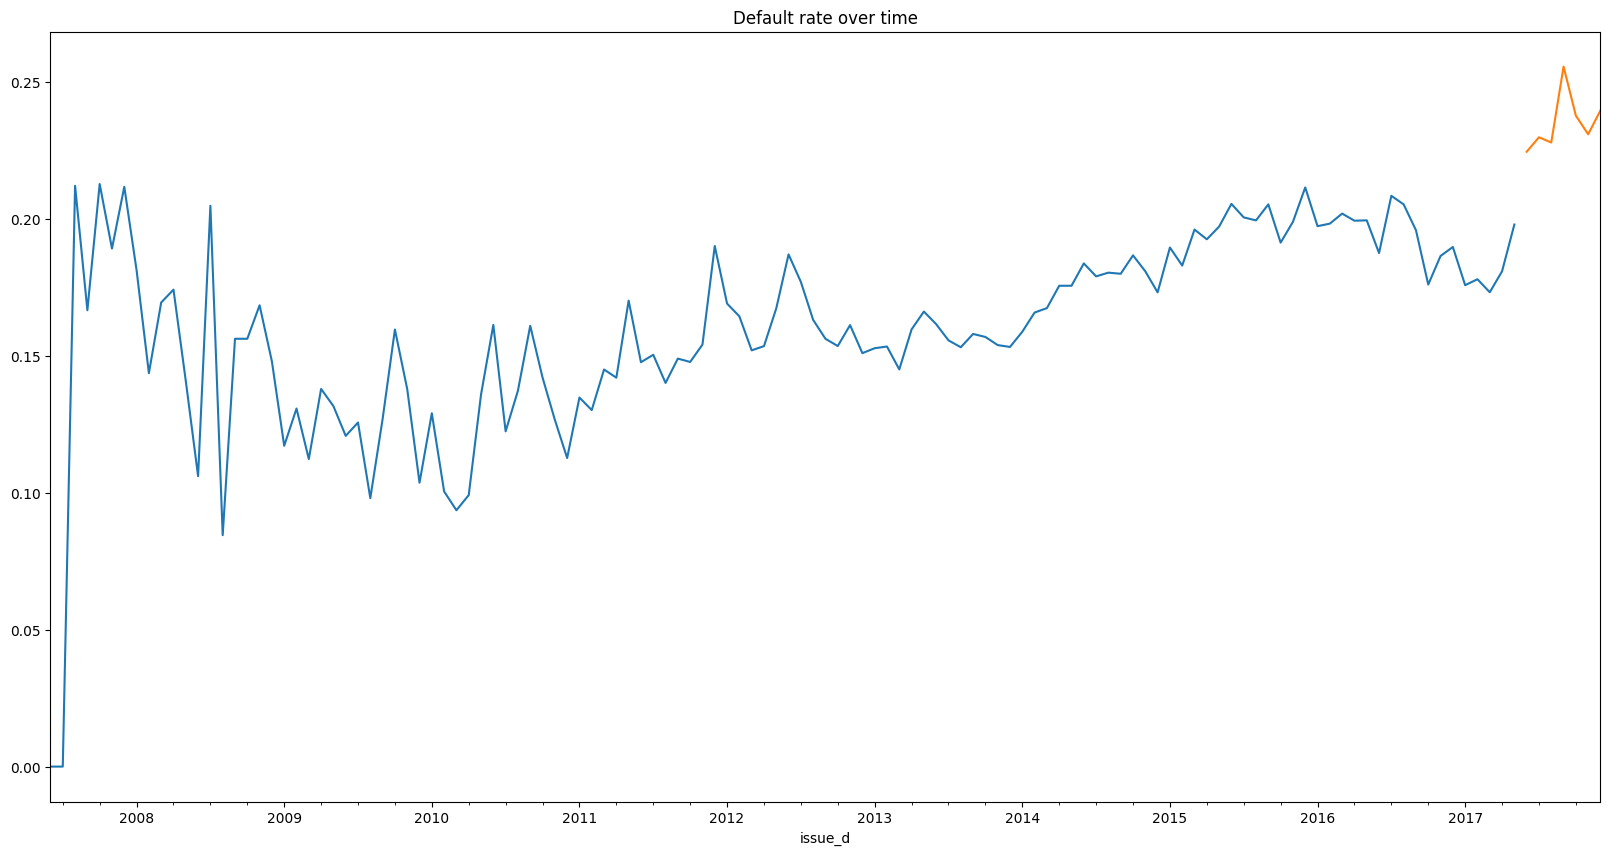

In [7]:
ax = (
    df_train
    .groupby('issue_d')
    ['default']
    .mean()
    .plot(figsize=(20, 10), title='Default rate over time')
)

(
    df_valid
    .groupby('issue_d')
    ['default']
    .mean()
    .plot(figsize=(20, 10), title='Default rate over time', ax=ax)
)

In [8]:
len(df_valid)

170828

# Feature Engineering   

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1412818 entries, 0 to 2925491
Columns: 107 entries, id to default
dtypes: Int16(51), Int32(12), Int64(15), category(14), datetime64[ns](3), float32(11), int64(1)
memory usage: 633.5 MB


In [10]:
def datetime_features(df, cols):
    df = df.copy()
    for col in cols:
        df[f'{col}_elapse'] = df[col].astype(int) / 1e9
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month.astype('category')
        df[f'{col}_day'] = df[col].dt.day.astype('category')
        df[f'{col}_dayofweek'] = df[col].dt.dayofweek.astype('category')
        df[f'{col}_dayofyear'] = df[col].dt.dayofyear.astype('category')
        df[f'{col}_quarter'] = df[col].dt.quarter.astype('category')
        if col != 'issue_d':
            df[f'{col}_since'] = (df['issue_d'] - df[col]).dt.days
            del df[col]
    return df

In [11]:
DATE_COLS = df_train.select_dtypes(include='datetime').columns
DATE_COLS

Index(['issue_d', 'earliest_cr_line', 'sec_app_earliest_cr_line'], dtype='object')

In [12]:
df_train = (
    df_train
    .pipe(datetime_features, DATE_COLS)
)

df_valid = (
    df_valid
    .pipe(datetime_features, DATE_COLS)
)

df_test = (
    df_test
    .pipe(datetime_features, DATE_COLS)
)

# Feature Selection

In [13]:
CATEGORICAL_FEATURES = df_train.select_dtypes(include='category').columns.to_list()

In [14]:
df_full = pd.concat([df_train, df_valid, df_test], ignore_index=True)
df_full[CATEGORICAL_FEATURES] = df_full[CATEGORICAL_FEATURES].astype(str).fillna('missing').astype('category')

df_train = df_full.merge(df_train[['id']], on='id', how='inner')
df_valid = df_full.merge(df_valid[['id']], on='id', how='inner')
df_test = df_full.merge(df_test[['id']], on='id', how='inner')

del df_full

In [15]:
df_train.issue_d.agg(['min', 'max'])    

min   2007-06-01
max   2017-05-01
Name: issue_d, dtype: datetime64[ns]

In [16]:
df_valid.issue_d.agg(['min', 'max'])  

min   2017-06-01
max   2017-12-01
Name: issue_d, dtype: datetime64[ns]

In [17]:
df_test.issue_d.agg(['min', 'max'])  

min   2018-01-01
max   2019-01-01
Name: issue_d, dtype: datetime64[ns]

In [18]:
# New cutoff for trianing set
cut_off_date = '2016-06-01'

In [19]:
FEATURES = [c for c in df_train.columns if c not in ['id', 'emp_title', 'default', 'issue_d']]
CATEGORICAL_FEATURES = [c for c in CATEGORICAL_FEATURES if c in FEATURES]

In [20]:
X_train = df_train.loc[df_train['issue_d'] < cut_off_date, FEATURES]
y_train = df_train.loc[df_train['issue_d'] < cut_off_date, 'default']
X_valid = df_train.loc[df_train['issue_d'] >= cut_off_date, FEATURES]
y_valid = df_train.loc[df_train['issue_d'] >= cut_off_date, 'default']

In [21]:
_, X_train, _, y_train = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [22]:
train_pool = cb.Pool(X_train, y_train, cat_features=CATEGORICAL_FEATURES)
valid_pool = cb.Pool(X_valid, y_valid, cat_features=CATEGORICAL_FEATURES)

In [24]:
mlflow.end_run()

Learning rate set to 0.131265
0:	learn: 0.6785445	test: 0.6784433	best: 0.6784433 (0)	total: 656ms	remaining: 10m 55s
10:	learn: 0.6280612	test: 0.6297230	best: 0.6297230 (10)	total: 4.82s	remaining: 7m 13s
20:	learn: 0.6202229	test: 0.6221228	best: 0.6221228 (20)	total: 9.35s	remaining: 7m 15s
30:	learn: 0.6169314	test: 0.6190155	best: 0.6190155 (30)	total: 13.9s	remaining: 7m 13s
40:	learn: 0.6149569	test: 0.6173503	best: 0.6173503 (40)	total: 18.1s	remaining: 7m 4s
50:	learn: 0.6133988	test: 0.6162181	best: 0.6162181 (50)	total: 21.8s	remaining: 6m 44s
60:	learn: 0.6123913	test: 0.6155718	best: 0.6155718 (60)	total: 25.3s	remaining: 6m 29s
70:	learn: 0.6113627	test: 0.6150327	best: 0.6150327 (70)	total: 29.2s	remaining: 6m 21s
80:	learn: 0.6105693	test: 0.6148290	best: 0.6148290 (80)	total: 33.2s	remaining: 6m 17s
90:	learn: 0.6095689	test: 0.6142099	best: 0.6142099 (90)	total: 37.1s	remaining: 6m 10s
100:	learn: 0.6086943	test: 0.6140030	best: 0.6140030 (100)	total: 41.4s	remaining

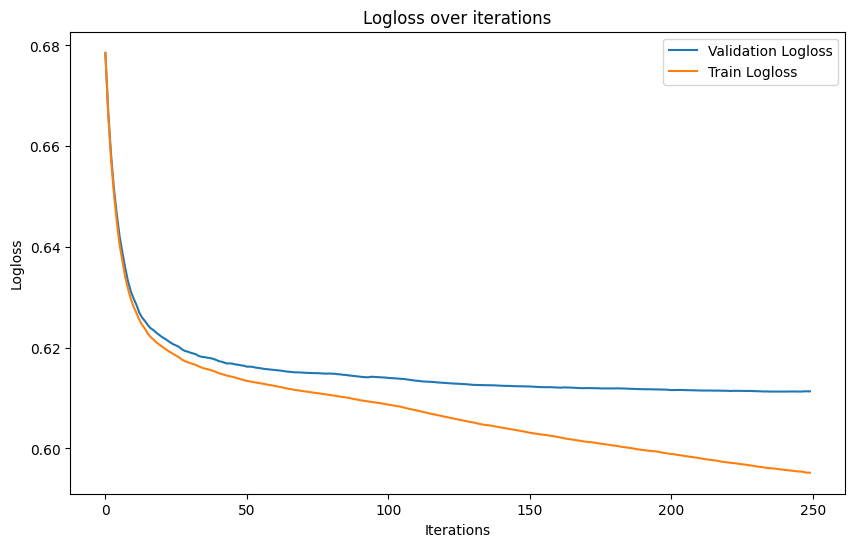

In [25]:
with mlflow.start_run(run_name='vanilla-Catboost'):
    params = dict(
        iterations=1000,
        depth=6,
        auto_class_weights='Balanced',
        eval_metric='Logloss',
        verbose=10,
    )

    model = cb.CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=10)
    y_pred = model.predict_proba(X_valid)[:, 1]
    mlflow.log_params(params)
    mlflow.log_metric('log_loss', log_loss(y_valid, y_pred))
    mlflow.log_metric('avg_pr', average_precision_score(y_valid, y_pred))

    # Plot logloss
    plt.figure(figsize=(10, 6))
    plt.plot(model.get_evals_result()['validation']['Logloss'], label='Validation Logloss')
    plt.plot(model.get_evals_result()['learn']['Logloss'], label='Train Logloss')
    plt.xlabel('Iterations')
    plt.ylabel('Logloss')
    plt.title('Logloss over iterations')
    plt.legend()

In [26]:
params = dict(
    depth=6,
    auto_class_weights='Balanced',
    eval_metric='Logloss',
)

model = cb.CatBoostClassifier(**params) 

feat_selector = arfsgroot.Leshy(
    model, n_estimators=150, verbose=10, max_iter=10, random_state=55, importance="fastshap",
)

feat_selector.fit(X_train.drop(CATEGORICAL_FEATURES, axis=1), y_train)

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]

Learning rate set to 0.5
0:	learn: 0.6507079	total: 47.9ms	remaining: 7.14s
1:	learn: 0.6344007	total: 89.3ms	remaining: 6.61s
2:	learn: 0.6276893	total: 130ms	remaining: 6.38s
3:	learn: 0.6249508	total: 168ms	remaining: 6.14s
4:	learn: 0.6225313	total: 209ms	remaining: 6.06s
5:	learn: 0.6213690	total: 245ms	remaining: 5.89s
6:	learn: 0.6204208	total: 283ms	remaining: 5.78s
7:	learn: 0.6194240	total: 323ms	remaining: 5.74s
8:	learn: 0.6187738	total: 368ms	remaining: 5.77s
9:	learn: 0.6183040	total: 409ms	remaining: 5.73s
10:	learn: 0.6177969	total: 455ms	remaining: 5.74s
11:	learn: 0.6170715	total: 510ms	remaining: 5.87s
12:	learn: 0.6166823	total: 543ms	remaining: 5.72s
13:	learn: 0.6164841	total: 577ms	remaining: 5.6s
14:	learn: 0.6162024	total: 607ms	remaining: 5.47s
15:	learn: 0.6159577	total: 640ms	remaining: 5.36s
16:	learn: 0.6154428	total: 675ms	remaining: 5.28s
17:	learn: 0.6152287	total: 709ms	remaining: 5.2s
18:	learn: 0.6147488	total: 745ms	remaining: 5.14s
19:	learn: 0.614

Leshy iteration:  10%|█         | 1/10 [00:13<02:01, 13.48s/it]

Learning rate set to 0.5
0:	learn: 0.6507079	total: 40.3ms	remaining: 6.01s
1:	learn: 0.6344168	total: 80.8ms	remaining: 5.97s
2:	learn: 0.6277087	total: 121ms	remaining: 5.94s
3:	learn: 0.6246145	total: 164ms	remaining: 5.97s
4:	learn: 0.6226091	total: 207ms	remaining: 6s
5:	learn: 0.6209546	total: 267ms	remaining: 6.4s
6:	learn: 0.6201463	total: 324ms	remaining: 6.63s
7:	learn: 0.6194356	total: 371ms	remaining: 6.59s
8:	learn: 0.6187447	total: 414ms	remaining: 6.48s
9:	learn: 0.6182782	total: 459ms	remaining: 6.42s
10:	learn: 0.6175273	total: 500ms	remaining: 6.32s
11:	learn: 0.6172220	total: 533ms	remaining: 6.13s
12:	learn: 0.6166624	total: 575ms	remaining: 6.06s
13:	learn: 0.6162037	total: 620ms	remaining: 6.02s
14:	learn: 0.6157915	total: 666ms	remaining: 6s
15:	learn: 0.6153559	total: 702ms	remaining: 5.88s
16:	learn: 0.6151361	total: 736ms	remaining: 5.76s
17:	learn: 0.6145679	total: 771ms	remaining: 5.65s
18:	learn: 0.6141920	total: 807ms	remaining: 5.56s
19:	learn: 0.6138241	

Leshy iteration:  20%|██        | 2/10 [00:25<01:41, 12.73s/it]

Learning rate set to 0.5
0:	learn: 0.6507079	total: 40.1ms	remaining: 5.97s
1:	learn: 0.6343791	total: 78.9ms	remaining: 5.84s
2:	learn: 0.6276657	total: 118ms	remaining: 5.8s
3:	learn: 0.6245734	total: 160ms	remaining: 5.83s
4:	learn: 0.6225607	total: 196ms	remaining: 5.69s
5:	learn: 0.6211309	total: 232ms	remaining: 5.56s
6:	learn: 0.6203017	total: 270ms	remaining: 5.51s
7:	learn: 0.6193610	total: 308ms	remaining: 5.46s
8:	learn: 0.6185946	total: 346ms	remaining: 5.42s
9:	learn: 0.6179436	total: 383ms	remaining: 5.37s
10:	learn: 0.6174700	total: 420ms	remaining: 5.31s
11:	learn: 0.6170232	total: 457ms	remaining: 5.25s
12:	learn: 0.6166169	total: 492ms	remaining: 5.18s
13:	learn: 0.6163891	total: 525ms	remaining: 5.1s
14:	learn: 0.6161422	total: 560ms	remaining: 5.04s
15:	learn: 0.6156429	total: 598ms	remaining: 5.01s
16:	learn: 0.6151556	total: 633ms	remaining: 4.95s
17:	learn: 0.6148332	total: 671ms	remaining: 4.92s
18:	learn: 0.6143494	total: 705ms	remaining: 4.86s
19:	learn: 0.613

Leshy iteration:  30%|███       | 3/10 [00:37<01:27, 12.44s/it]

Learning rate set to 0.5
0:	learn: 0.6484534	total: 39.7ms	remaining: 5.92s
1:	learn: 0.6336644	total: 83.9ms	remaining: 6.21s
2:	learn: 0.6266573	total: 121ms	remaining: 5.91s
3:	learn: 0.6240943	total: 153ms	remaining: 5.6s
4:	learn: 0.6226175	total: 193ms	remaining: 5.59s
5:	learn: 0.6214313	total: 227ms	remaining: 5.46s
6:	learn: 0.6203378	total: 265ms	remaining: 5.42s
7:	learn: 0.6195414	total: 300ms	remaining: 5.33s
8:	learn: 0.6182650	total: 338ms	remaining: 5.3s
9:	learn: 0.6176690	total: 373ms	remaining: 5.23s
10:	learn: 0.6172447	total: 412ms	remaining: 5.2s
11:	learn: 0.6167600	total: 448ms	remaining: 5.15s
12:	learn: 0.6163268	total: 487ms	remaining: 5.13s
13:	learn: 0.6158583	total: 525ms	remaining: 5.1s
14:	learn: 0.6155986	total: 559ms	remaining: 5.03s
15:	learn: 0.6152288	total: 597ms	remaining: 5s
16:	learn: 0.6149257	total: 635ms	remaining: 4.97s
17:	learn: 0.6146599	total: 673ms	remaining: 4.94s
18:	learn: 0.6141898	total: 719ms	remaining: 4.95s
19:	learn: 0.6138222	

Leshy iteration:  40%|████      | 4/10 [00:50<01:14, 12.48s/it]

Learning rate set to 0.5
0:	learn: 0.6507079	total: 46ms	remaining: 6.86s
1:	learn: 0.6344200	total: 90.2ms	remaining: 6.67s
2:	learn: 0.6277094	total: 129ms	remaining: 6.31s
3:	learn: 0.6248365	total: 165ms	remaining: 6.04s
4:	learn: 0.6223277	total: 203ms	remaining: 5.88s
5:	learn: 0.6206516	total: 238ms	remaining: 5.71s
6:	learn: 0.6193327	total: 278ms	remaining: 5.68s
7:	learn: 0.6187197	total: 310ms	remaining: 5.5s
8:	learn: 0.6181025	total: 345ms	remaining: 5.41s
9:	learn: 0.6175759	total: 382ms	remaining: 5.35s
10:	learn: 0.6171315	total: 419ms	remaining: 5.29s
11:	learn: 0.6165243	total: 458ms	remaining: 5.27s
12:	learn: 0.6163128	total: 490ms	remaining: 5.16s
13:	learn: 0.6160037	total: 523ms	remaining: 5.08s
14:	learn: 0.6157061	total: 557ms	remaining: 5.01s
15:	learn: 0.6152183	total: 592ms	remaining: 4.96s
16:	learn: 0.6146938	total: 628ms	remaining: 4.91s
17:	learn: 0.6144447	total: 664ms	remaining: 4.87s
18:	learn: 0.6140302	total: 702ms	remaining: 4.84s
19:	learn: 0.6136

Leshy iteration:  50%|█████     | 5/10 [01:02<01:01, 12.29s/it]

Learning rate set to 0.5
0:	learn: 0.6507079	total: 42.7ms	remaining: 6.36s
1:	learn: 0.6343940	total: 81.9ms	remaining: 6.06s
2:	learn: 0.6276830	total: 120ms	remaining: 5.87s
3:	learn: 0.6247816	total: 157ms	remaining: 5.72s
4:	learn: 0.6222749	total: 194ms	remaining: 5.61s
5:	learn: 0.6205990	total: 229ms	remaining: 5.49s
6:	learn: 0.6194465	total: 269ms	remaining: 5.49s
7:	learn: 0.6188673	total: 304ms	remaining: 5.4s
8:	learn: 0.6181880	total: 340ms	remaining: 5.32s
9:	learn: 0.6176996	total: 373ms	remaining: 5.21s
10:	learn: 0.6170863	total: 412ms	remaining: 5.2s
11:	learn: 0.6168710	total: 441ms	remaining: 5.07s
12:	learn: 0.6164319	total: 479ms	remaining: 5.04s
13:	learn: 0.6157945	total: 556ms	remaining: 5.4s
14:	learn: 0.6154228	total: 596ms	remaining: 5.37s
15:	learn: 0.6150345	total: 642ms	remaining: 5.38s
16:	learn: 0.6148426	total: 687ms	remaining: 5.37s
17:	learn: 0.6143881	total: 727ms	remaining: 5.33s
18:	learn: 0.6140536	total: 766ms	remaining: 5.28s
19:	learn: 0.6137

Leshy iteration:  60%|██████    | 6/10 [01:15<00:50, 12.63s/it]

Learning rate set to 0.5
0:	learn: 0.6507079	total: 43.6ms	remaining: 6.49s
1:	learn: 0.6344085	total: 84.3ms	remaining: 6.24s
2:	learn: 0.6276955	total: 125ms	remaining: 6.12s
3:	learn: 0.6246023	total: 167ms	remaining: 6.08s
4:	learn: 0.6225981	total: 211ms	remaining: 6.11s
5:	learn: 0.6209439	total: 259ms	remaining: 6.21s
6:	learn: 0.6201039	total: 294ms	remaining: 6.01s
7:	learn: 0.6193997	total: 332ms	remaining: 5.88s
8:	learn: 0.6185832	total: 366ms	remaining: 5.74s
9:	learn: 0.6181233	total: 408ms	remaining: 5.71s
10:	learn: 0.6174219	total: 448ms	remaining: 5.67s
11:	learn: 0.6171707	total: 482ms	remaining: 5.54s
12:	learn: 0.6167367	total: 518ms	remaining: 5.46s
13:	learn: 0.6161206	total: 558ms	remaining: 5.42s
14:	learn: 0.6158280	total: 598ms	remaining: 5.38s
15:	learn: 0.6154666	total: 634ms	remaining: 5.31s
16:	learn: 0.6151863	total: 679ms	remaining: 5.31s
17:	learn: 0.6145746	total: 718ms	remaining: 5.26s
18:	learn: 0.6143164	total: 756ms	remaining: 5.21s
19:	learn: 0.6

Leshy iteration:  70%|███████   | 7/10 [01:28<00:38, 12.81s/it]

Learning rate set to 0.5
0:	learn: 0.6507079	total: 41.9ms	remaining: 6.24s
1:	learn: 0.6344122	total: 84.8ms	remaining: 6.27s
2:	learn: 0.6276999	total: 124ms	remaining: 6.06s
3:	learn: 0.6248514	total: 163ms	remaining: 5.95s
4:	learn: 0.6223429	total: 203ms	remaining: 5.89s
5:	learn: 0.6206676	total: 345ms	remaining: 8.28s
6:	learn: 0.6193500	total: 407ms	remaining: 8.3s
7:	learn: 0.6187405	total: 445ms	remaining: 7.89s
8:	learn: 0.6181299	total: 484ms	remaining: 7.58s
9:	learn: 0.6176570	total: 535ms	remaining: 7.49s
10:	learn: 0.6171561	total: 581ms	remaining: 7.34s
11:	learn: 0.6166080	total: 633ms	remaining: 7.28s
12:	learn: 0.6164384	total: 665ms	remaining: 7.01s
13:	learn: 0.6161996	total: 701ms	remaining: 6.8s
14:	learn: 0.6159543	total: 735ms	remaining: 6.61s
15:	learn: 0.6155679	total: 771ms	remaining: 6.46s
16:	learn: 0.6151036	total: 807ms	remaining: 6.31s
17:	learn: 0.6146552	total: 845ms	remaining: 6.2s
18:	learn: 0.6144577	total: 885ms	remaining: 6.1s
19:	learn: 0.61414

Leshy iteration:  80%|████████  | 8/10 [01:41<00:25, 12.78s/it]

Learning rate set to 0.5
0:	learn: 0.6505747	total: 27.9ms	remaining: 4.16s
1:	learn: 0.6340217	total: 56.9ms	remaining: 4.21s
2:	learn: 0.6287354	total: 89.6ms	remaining: 4.39s
3:	learn: 0.6253367	total: 119ms	remaining: 4.34s
4:	learn: 0.6232541	total: 155ms	remaining: 4.5s
5:	learn: 0.6215133	total: 185ms	remaining: 4.45s
6:	learn: 0.6206825	total: 233ms	remaining: 4.76s
7:	learn: 0.6197983	total: 265ms	remaining: 4.7s
8:	learn: 0.6191092	total: 296ms	remaining: 4.64s
9:	learn: 0.6182228	total: 417ms	remaining: 5.83s
10:	learn: 0.6177803	total: 464ms	remaining: 5.86s
11:	learn: 0.6172871	total: 501ms	remaining: 5.76s
12:	learn: 0.6168821	total: 532ms	remaining: 5.61s
13:	learn: 0.6164032	total: 564ms	remaining: 5.48s
14:	learn: 0.6160131	total: 594ms	remaining: 5.35s
15:	learn: 0.6157197	total: 623ms	remaining: 5.22s
16:	learn: 0.6155247	total: 651ms	remaining: 5.09s
17:	learn: 0.6152827	total: 684ms	remaining: 5.02s
18:	learn: 0.6148506	total: 718ms	remaining: 4.95s
19:	learn: 0.61

Leshy iteration:  90%|█████████ | 9/10 [01:50<00:12, 12.31s/it]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	30
Tentative: 	13
Rejected: 	53
All relevant predictors selected in 00:01:51.49



The Leshy or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.


Leshy(estimator=<catboost.core.CatBoostClassifier object at 0x152d46650>,
      importance='fastshap', max_iter=10, n_estimators=150,
      random_state=RandomState(MT19937) at 0x117572C40, verbose=10)

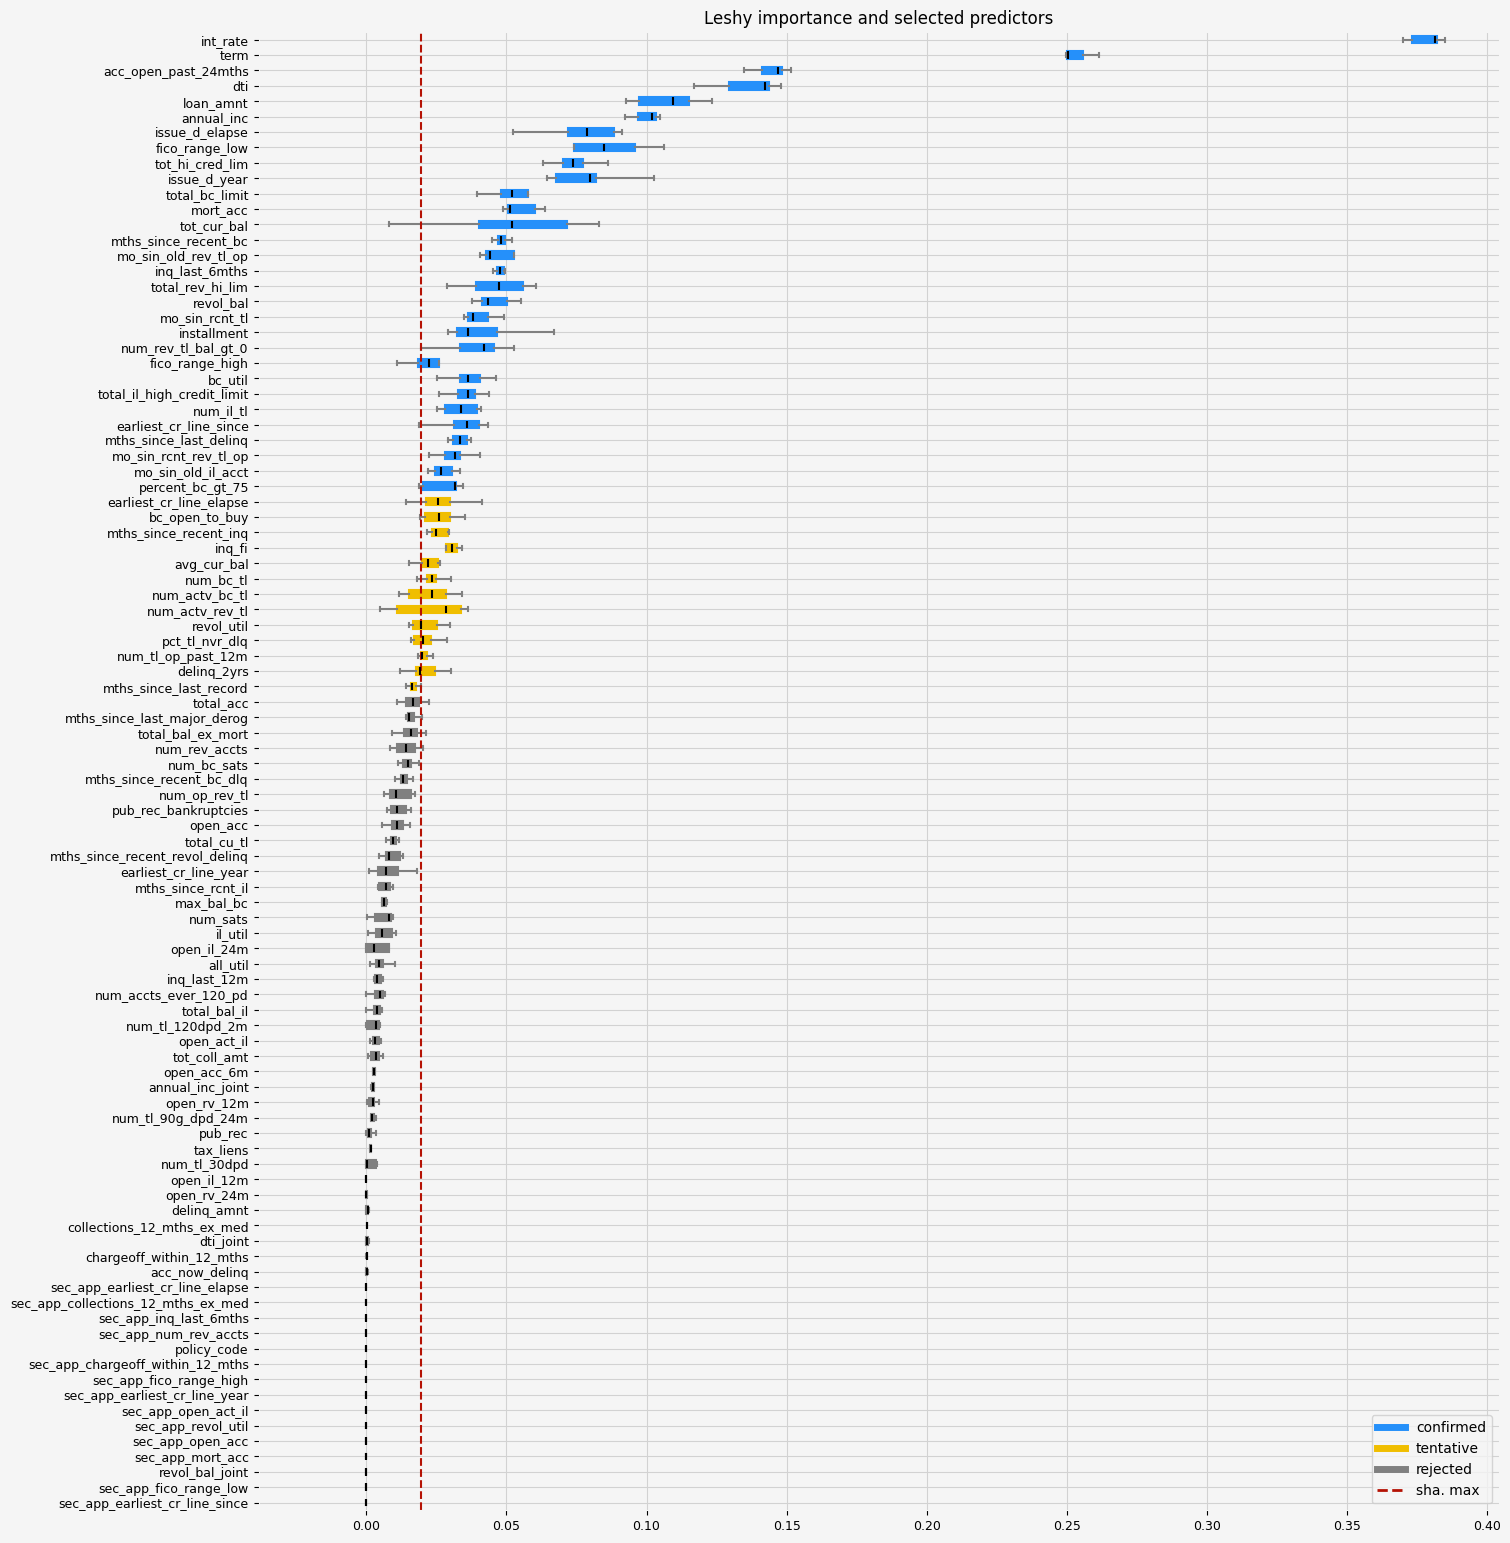

In [27]:
feat_selector.plot_importance();

In [30]:
SELECTED_FEATURES = feat_selector.selected_features_.tolist() + CATEGORICAL_FEATURES
SELECTED_FEATURES 

['loan_amnt',
 'term',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'fico_range_low',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'revol_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'bc_open_to_buy',
 'bc_util',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_bc_tl',
 'num_il_tl',
 'num_rev_tl_bal_gt_0',
 'percent_bc_gt_75',
 'tot_hi_cred_lim',
 'total_bc_limit',
 'total_il_high_credit_limit',
 'issue_d_elapse',
 'earliest_cr_line_since',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'initial_list_status',
 'application_type',
 'verification_status_joint',
 'issue_d_month',
 'issue_d_day',
 'issue_d_dayofweek',
 'issue_d_dayofyear',
 'issue_d_quarter',
 'earliest_cr_line_month',
 'earliest_cr_line_day',
 'earliest_cr_line_dayofweek',
 'earliest_cr_line_d

In [31]:
train_pool = cb.Pool(X_train[SELECTED_FEATURES], y_train, cat_features=CATEGORICAL_FEATURES)
valid_pool = cb.Pool(X_valid[SELECTED_FEATURES], y_valid, cat_features=CATEGORICAL_FEATURES)

Learning rate set to 0.131265
0:	learn: 0.6780449	test: 0.6806528	best: 0.6806528 (0)	total: 442ms	remaining: 7m 21s
10:	learn: 0.6281427	test: 0.6310830	best: 0.6310830 (10)	total: 4.25s	remaining: 6m 21s
20:	learn: 0.6204742	test: 0.6229124	best: 0.6229124 (20)	total: 7.92s	remaining: 6m 9s
30:	learn: 0.6170397	test: 0.6192933	best: 0.6192933 (30)	total: 11.8s	remaining: 6m 8s
40:	learn: 0.6152825	test: 0.6177545	best: 0.6177545 (40)	total: 15.5s	remaining: 6m 3s
50:	learn: 0.6138840	test: 0.6166630	best: 0.6166630 (50)	total: 19.5s	remaining: 6m 2s
60:	learn: 0.6125792	test: 0.6157889	best: 0.6157889 (60)	total: 23.8s	remaining: 6m 5s
70:	learn: 0.6114459	test: 0.6150774	best: 0.6150774 (70)	total: 28.3s	remaining: 6m 9s
80:	learn: 0.6105745	test: 0.6148234	best: 0.6148234 (80)	total: 32.8s	remaining: 6m 12s
90:	learn: 0.6098140	test: 0.6145475	best: 0.6145475 (90)	total: 37s	remaining: 6m 9s
100:	learn: 0.6087462	test: 0.6141672	best: 0.6141672 (100)	total: 40.8s	remaining: 6m 3s
1

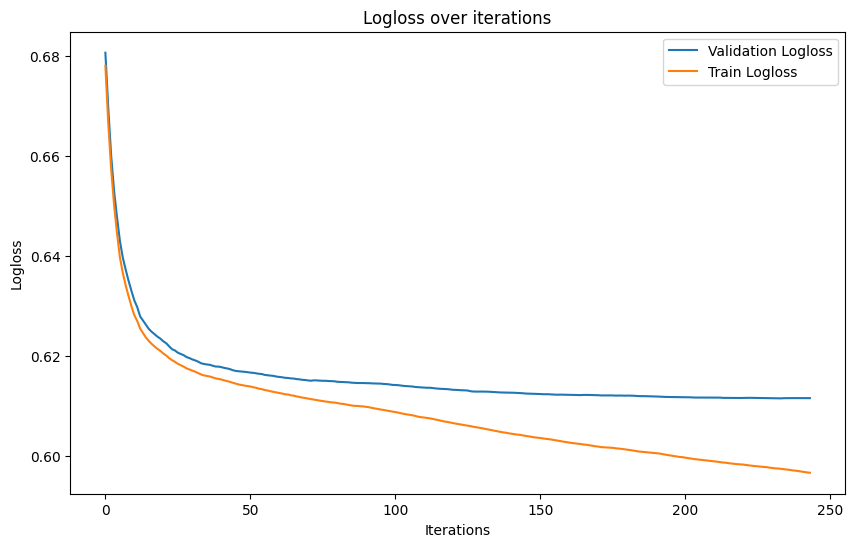

In [32]:
with mlflow.start_run(run_name='FS-Catboost'):
    params = dict(
        iterations=1000,
        depth=6,
        auto_class_weights='Balanced',
        eval_metric='Logloss',
        verbose=10,
    )

    model = cb.CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=10)
    y_pred = model.predict_proba(X_valid[SELECTED_FEATURES])[:, 1]
    mlflow.log_params(params)
    mlflow.log_metric('log_loss', log_loss(y_valid, y_pred))
    mlflow.log_metric('avg_pr', average_precision_score(y_valid, y_pred))
    with open('features.txt', 'w') as f:
        f.write('\n'.join(SELECTED_FEATURES))
    mlflow.log_artifact('features.txt')

    # Plot logloss
    plt.figure(figsize=(10, 6))
    plt.plot(model.get_evals_result()['validation']['Logloss'], label='Validation Logloss')
    plt.plot(model.get_evals_result()['learn']['Logloss'], label='Train Logloss')
    plt.xlabel('Iterations')
    plt.ylabel('Logloss')
    plt.title('Logloss over iterations')
    plt.legend()

In [34]:
df_train[['id', 'default', 'issue_d'] + SELECTED_FEATURES].to_parquet('./case/data/processed/lending_club_case_train_dataset_v2.parquet')
df_valid[['id', 'default', 'issue_d'] + SELECTED_FEATURES].to_parquet('./case/data/processed/lending_club_case_valid_dataset_v2.parquet')
df_test[['id', 'issue_d'] + SELECTED_FEATURES].to_parquet('./case/data/processed/lending_club_case_test_dataset_v2.parquet')